In [5]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
import pprint
%matplotlib inline

np.savetxt("historycost.csv", [0, 0], delimiter=",") #to save cost during multiple training times due to limited Ressources: RAM, ...
historyCost = np.genfromtxt('historycost.csv', delimiter=',').tolist()

In [6]:
#utils
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [7]:
#Hyperparams

img_size = 200
learning_rate = 0.001 #low learning tend to give better result in this case but slower :')
style_weight=10
content_weight=40
beta_1=0.99
epsilon=1e-1

#choosen layers for style & content (see the model layers in its summary)
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]
content_layer = [('block5_conv4', 1)]

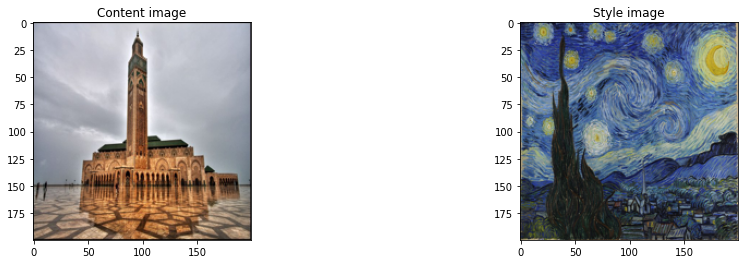

In [8]:
#Load images
content_image = np.array(Image.open("mosque.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

style_image =  np.array(Image.open("starry_night_full.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 2, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
plt.show()

In [9]:
#Loading the model
pp = pprint.PrettyPrinter(indent=4)
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='imagenet')

vgg.trainable = False
pp.pprint(vgg)
vgg.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
______________________________________________________________


$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$



$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$



In [10]:
#calculations: cost, Gram...
def compute_content_cost(content_output, generated_output):
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    m, n_H, n_W, n_C = a_C.get_shape().as_list()

    a_C_unrolled = tf.transpose( tf.reshape(a_C, shape=[m, -1, n_C] ) )
    a_G_unrolled = tf.transpose( tf.reshape(a_G, shape=[m, -1, n_C] ) )
    J_content = (1/4/n_C/n_H/n_W) * tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))
    
    return J_content

def gram_matrix(A):
    GA = tf.linalg.matmul(A, tf.transpose(A))
    return GA

def compute_layer_style_cost(a_S, a_G):
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose( tf.reshape(a_S, shape=[n_H*n_W, n_C] ) )
    a_G = tf.transpose( tf.reshape(a_G, shape=[n_H*n_W, n_C] ) )
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    
    J_style_layer = ( 1/(4 * n_C**2 *(n_H*n_W)**2 )  ) * tf.reduce_sum(tf.reduce_sum( tf.square( tf.subtract( GS,GG ) ) ) )
        
    return J_style_layer

def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    J_style = 0
    a_S = style_image_output[:-1]
    a_G = generated_image_output[:-1]
    
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

In [11]:
# Total cost
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    return alpha*J_content + beta*J_style

In [12]:
#VGG model layer names
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [13]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [14]:
vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [15]:
content_target = vgg_model_outputs(content_image)  
style_targets = vgg_model_outputs(style_image)     

In [16]:
#calculating style & content output to be used in the training

preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)
a_C = vgg_model_outputs(preprocessed_content)


In [17]:

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1 =beta_1, epsilon= epsilon)

#total_variation_weight = 30

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        a_G = vgg_model_outputs(generated_image)

        J_style = compute_style_cost(a_S, a_G, STYLE_LAYERS=STYLE_LAYERS)
        J_content = compute_content_cost(a_C, a_G)
        # Compute the total cost
        J = total_cost(J_content, J_style, alpha = content_weight, beta= style_weight )
        
    grad = tape.gradient(J, generated_image)
    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    return J

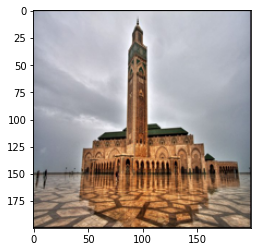

In [18]:
#initializing the generated image from content image :)

generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
imshow(generated_image.numpy()[0])
plt.show()


In [19]:
# If I load stored image progress from a previous training : change myStoredImage.jpg to your  image
# temp_generated_image = np.array(Image.open("myStoredImage.jpg").resize((img_size, img_size)))
# temp_generated_image = tf.constant(np.reshape(temp_generated_image, ((1,) + temp_generated_image.shape)))
# generated_image = tf.Variable(tf.image.convert_image_dtype(temp_generated_image, tf.float32))

In [20]:
#test one step
train_step(generated_image)

<tf.Tensor: shape=(), dtype=float32, numpy=5111.733>

Epoch 0 


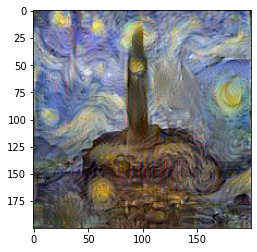

Epoch 250 


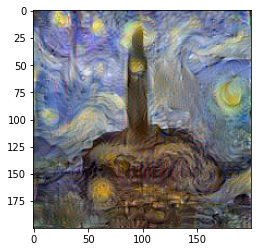

Epoch 500 


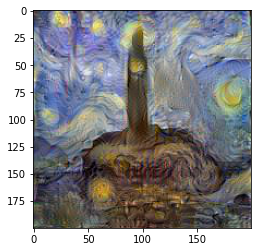

Epoch 750 


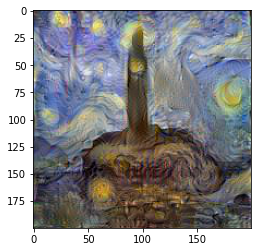

Epoch 1000 


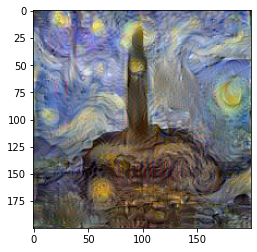

Epoch 1250 


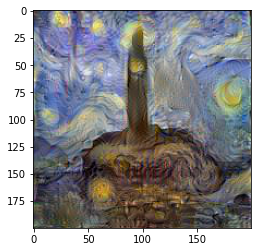

Epoch 1500 


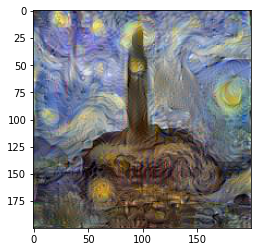

Epoch 1750 


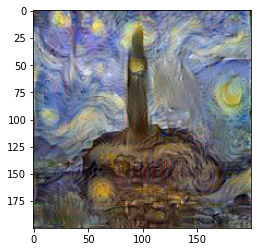

Epoch 2000 


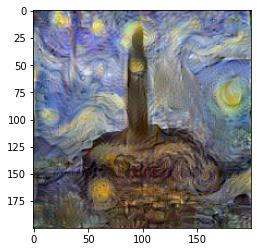

Epoch 2250 


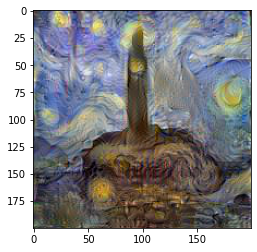

Epoch 2500 


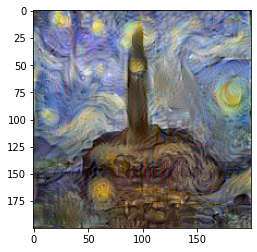

Epoch 2750 


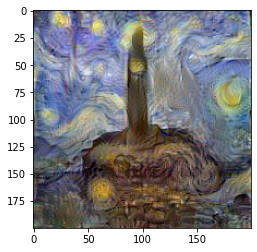

Epoch 3000 


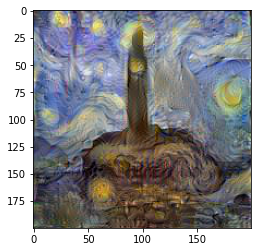

Epoch 3250 


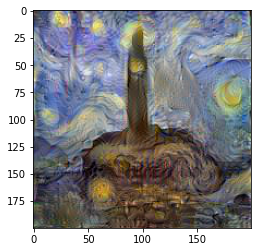

Epoch 3500 


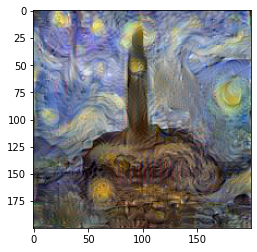

Epoch 3750 


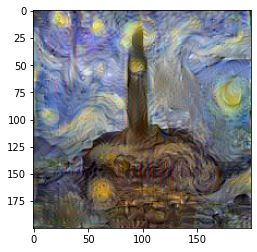

Epoch 4000 


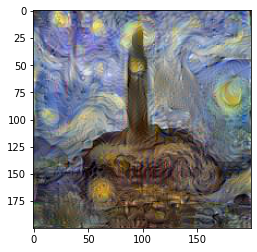

Epoch 4250 


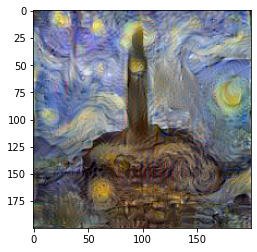

Epoch 4500 


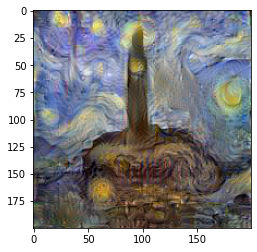

Epoch 4750 


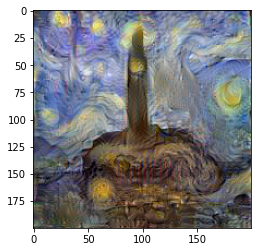

Epoch 5000 


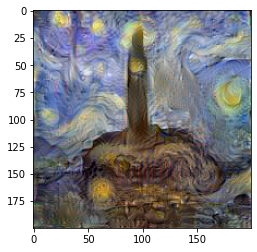

Epoch 5250 


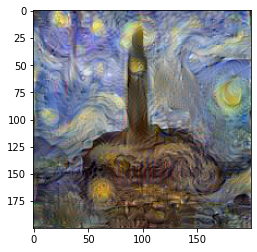

Epoch 5500 


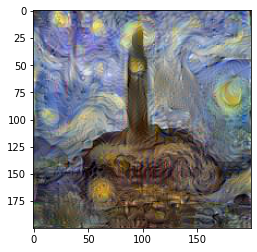

Epoch 5750 


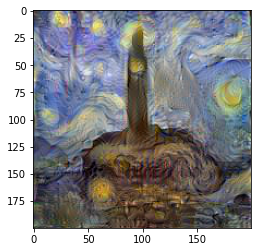

Epoch 6000 


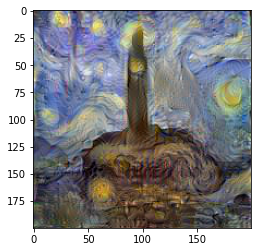

Epoch 6250 


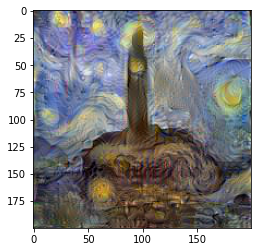

Epoch 6500 


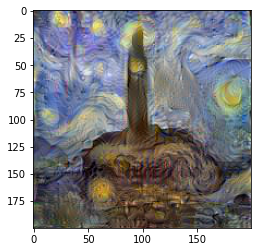

Epoch 6750 


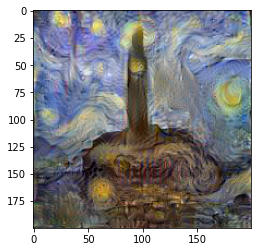

Epoch 7000 


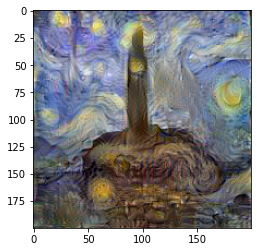

In [ ]:
# Show the generated image at some epochs
# !!! to reset the style transfer process. You will need to compile the train_step function again !!!
epochs = 12001
for i in range(epochs):
    J = train_step(generated_image)
    if i % 250 == 0:
        historyCost.append(float(J))
        print(f"Epoch {i} ")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"output/imagev40_{i}.jpg")
        plt.show() 

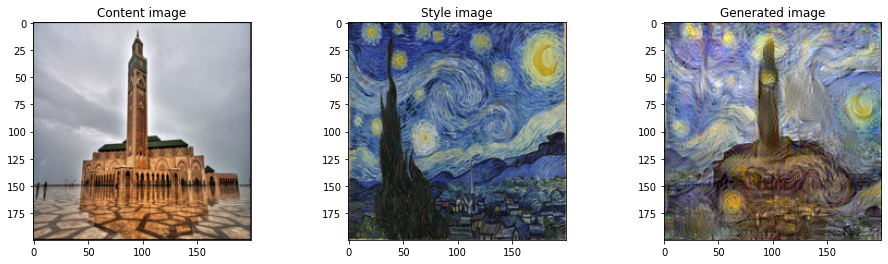

In [32]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()

In [ ]:
#showing cost evolution 
historyCost = [x for x in historyCost if x <= 3]
plt.plot(historyCost)
plt.show()
np.savetxt("historycost.csv", historyCost, delimiter=",")

In [ ]:
#historyCost

In [ ]:
#  download output images
#  !zip -r /content/output.zip /content/output
#  from google.colab import files
#  files.download("/content/output.zip")